# Initialization

In [ ]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import backend as K

In [ ]:
data_dir = "drive/MyDrive/University/7 semestras/Kursinis/data"
images_dir = os.path.join(data_dir, "images")
resized_images_dir = os.path.join(data_dir, "resized_images")
masks_dir = os.path.join(data_dir, "masks")
resized_masks_dir = os.path.join(data_dir, "resized_masks")
checkpoint_dir = os.path.join(data_dir, "checkpoints")
model_augmented_dir = os.path.join(data_dir, "model_augmented")
checkpoints_augmented_dir = os.path.join(data_dir, "checkpoints_augmented")
log_dir = os.path.join(data_dir, "training.log")
figures_dir = os.path.join(data_dir, "figures")
saved_datasets_dir = os.path.join(data_dir, "saved_datasets")

In [ ]:
INPUT_SHAPE = (256, 256)
BATCH_SIZE = 4

# Base images processing and saving to Drive

First resize all base dataset's images to one size and save, so we don't have to resize them again

In [ ]:
for dir in [images_dir, masks_dir]:
  for i, img_name in enumerate(os.listdir(dir)):
    image_path = os.path.join(dir, img_name)
    img = cv.imread(image_path)
    resized_img = cv.resize(img, (INPUT_SHAPE[0], INPUT_SHAPE[1]), interpolation=cv.INTER_AREA)

    cv.imwrite(os.path.join(resized_images_dir if "images" in dir else resized_masks_dir, img_name), resized_img)

# Utility functions

In [ ]:
def show_image(img, cmap='gray'):
  plt.imshow(img, cmap=cmap)
  plt.show()

def show_all_images(*images):
  fig = plt.figure(figsize=(10, 7))
  # setting values to rows and column variables
  rows = 1
  columns = len(images)
  for i, image in enumerate(images):
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i + 1)

    # showing image
    plt.imshow(image, cmap='gray')
    plt.axis('off')

def show_images(labels, *images):
  fig = plt.figure(figsize=(10, 7))
  # setting values to rows and column variables
  rows = 1
  columns = len(images)

  for i, image in enumerate(images):
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i + 1)

    # showing image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(labels[i] if i + 1 <= len(labels) else i)

In [ ]:
from PIL import Image
def save_numpy_as_image(array, path):
    """
    Saves a numpy array as an image.

    Parameters:
        array (numpy.ndarray): The image data as a numpy array.
        path (str): The path where the image will be saved.
    """
    # If the image is binary (i.e., has a shape like (256, 256, 1)),
    # we should first remove the singleton dimension before saving it
    if array.ndim == 3 and array.shape[-1] == 1:
        array = array.squeeze(-1)

    # Convert the numpy array to a PIL image
    image = Image.fromarray(np.uint8(array * 255))

    # Save the image
    image.save(path)

    print(f"Image saved as {path}")

# Data: preprocessing

### Load raw images and their masks

In [ ]:
def load_images_and_masks(images_dir, masks_dir):
  images_arr = []
  masks_arr = []
  for i, img_name in enumerate(os.listdir(masks_dir)):
    image_path = os.path.join(images_dir, img_name)
    mask_path = image_path.replace(images_dir, masks_dir)
    img = cv.imread(image_path)

    if (os.path.isfile(mask_path)):
      mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
      mask = np.expand_dims(mask, axis=-1)
      images_arr.append(img)
      masks_arr.append(mask)

  return (images_arr, masks_arr)

(raw_images, raw_masks) = load_images_and_masks(resized_images_dir, resized_masks_dir)

## Load preprocessed images from drive

### Load datasets from drive

In [ ]:
train_dir = os.path.join(saved_datasets_dir, "train")
val_dir = os.path.join(saved_datasets_dir, "val")
test_dir = os.path.join(saved_datasets_dir, "test")

In [ ]:
def load_dataset_from_drive(dir):
  images = []
  labels = []
  all_files = os.listdir(dir)
  size = int(len(all_files) / 2)
  for i in range(0, size):
    image_dir = os.path.join(dir, "image-" + str(i) + ".jpg")
    label_dir = os.path.join(dir, "label-" + str(i) + ".jpg")
    image = cv.imread(image_dir)
    label = cv.imread(label_dir, cv.IMREAD_GRAYSCALE)
    label = np.expand_dims(label, axis = -1)
    images.append(image)
    labels.append(label)

  # Normalize the images and masks
  images = np.array(images, dtype=np.float32) / 255.0
  labels = np.array(labels, dtype=np.float32) / 255.0

  return (images, labels)

x_train, y_train = load_dataset_from_drive(train_dir)
x_val, y_val = load_dataset_from_drive(val_dir)
x_test, y_test = load_dataset_from_drive(test_dir)

### Convert images to HSV

In [ ]:
def convert_rgb_to_hsv(image):
  # Convert RGB image to HSV
  image = (image * 255).astype(np.uint8)
  hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
  return hsv_image / 255.0

def convert_dataset_to_hsv(ds_images):
  return np.array(list(map(lambda image: convert_rgb_to_hsv(image), ds_images)))

In [ ]:
# x_train_hsv = convert_dataset_to_hsv(x_train)
# x_val_hsv = convert_dataset_to_hsv(x_val)
# x_test_hsv = convert_dataset_to_hsv(x_test)
x_train = convert_dataset_to_hsv(x_train)
x_val = convert_dataset_to_hsv(x_val)
x_test = convert_dataset_to_hsv(x_test)

### Convert images to greyscale

In [ ]:
def convert_rgb_to_greyscale(image):
  # Convert RGB image to grey
  image = (image * 255).astype(np.uint8)
  grey_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
  return grey_image / 255.0

def convert_dataset_to_greyscale(ds_images):
  return np.array(list(map(lambda image: convert_rgb_to_greyscale(image), ds_images)))

In [ ]:
x_train = convert_dataset_to_greyscale(x_train)
x_val = convert_dataset_to_greyscale(x_val)
x_test = convert_dataset_to_greyscale(x_test)

In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

(41, 256, 256, 1, 1)


### Convert images to Gaussian blur

In [ ]:
def apply_gauss_blur(image, kernel_size=(5, 5), sigma_x=0):
  image = (image * 255).astype(np.uint8)
  # Apply Gaussian blur
  blurred_image = cv.GaussianBlur(image, kernel_size, sigma_x)
  return blurred_image / 255.0

def convert_dataset_to_gauss_blur(ds_images):
  return np.array(list(map(lambda image: apply_gauss_blur(image), ds_images)))

In [ ]:
x_train = convert_dataset_to_gauss_blur(x_train)
x_val = convert_dataset_to_gauss_blur(x_val)
x_test = convert_dataset_to_gauss_blur(x_test)

### Convert images to bilateral blur

In [ ]:
def apply_bilateral_filter(image, diameter=9, sigma_color=75, sigma_space=75):
    image = (image * 255).astype(np.uint8)
    # Apply bilateral filter
    filtered_image = cv.bilateralFilter(image, diameter, sigma_color, sigma_space)
    return filtered_image / 255.0

def convert_dataset_to_bilat_blur(ds_images):
  return np.array(list(map(lambda image: apply_bilateral_filter(image), ds_images)))

In [ ]:
x_train = convert_dataset_to_bilat_blur(x_train)
x_val = convert_dataset_to_bilat_blur(x_val)
x_test = convert_dataset_to_bilat_blur(x_test)

### Convert lists to TF datasets

In [ ]:
# Convert your NumPy arrays into a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Cache, shuffle, batch, and prefetch the combined dataset
train_dataset = train_dataset.cache().shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# For the validation dataset, no augmentation is applied
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
# For the test dataset, no augmentation is applied
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

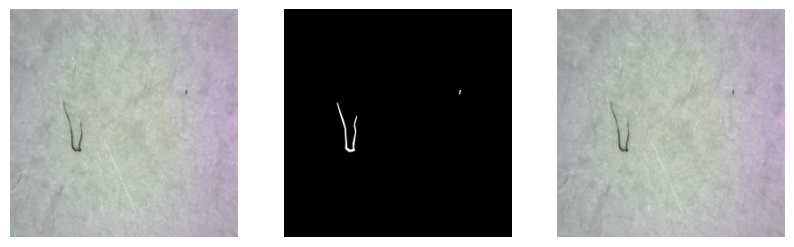

In [ ]:
show_all_images(x_test[0], y_test[0], x_test[0])

## Preprocess images and split to datasets

### Define augmentation function

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

# Apply data augmentation on-the-fly using tf.data and map
def augment(image, mask, override_augmentation=None):
    number = override_augmentation or random.randint(0, 3)

    # Flip the image and mask horizontally
    if (number == 0):
      new_image = tf.image.flip_left_right(image)
      new_mask = tf.image.flip_left_right(mask)
    # Flip the image and mask vertically
    elif (number == 1):
      new_image = tf.image.flip_up_down(image)
      new_mask = tf.image.flip_up_down(mask)
    # Zoom in 70%
    elif (number == 2):
      new_image = tf.image.central_crop(image, central_fraction=0.8)  # Zoom in to 70% of the image
      new_image = tf.image.resize(new_image, [INPUT_SHAPE[0], INPUT_SHAPE[1]])
      new_mask = tf.image.central_crop(mask, central_fraction=0.8)
      new_mask = tf.image.resize(new_mask, [INPUT_SHAPE[0], INPUT_SHAPE[1]])
    # Randomly rotate the image and mask
    # Concatenate image and mask to make sure the same rotation is applied
    else:
      combined = tf.concat([image, mask], axis=-1)
      # rotations = tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32)
      rotations = 1
      combined = tf.image.rot90(combined, rotations)
      new_image, new_mask = tf.split(combined, [image.shape[-1], mask.shape[-1]], axis=-1)

    new_mask = tf.round(new_mask)

    return new_image, new_mask

### Normalize and augment images

In [ ]:
# Normalize the images and masks
images = np.array(raw_images, dtype=np.float32) / 255.0
masks = np.array(raw_masks, dtype=np.float32) / 255.0

# Augment the same images
augment_fun = lambda image_mask: augment(*image_mask)
augmented_pairs = [augment_fun(pair) for pair in zip(images, masks)]
augmented_images, augmented_masks = zip(*augmented_pairs)

# Concatenate non-augmented and augmented images
images = np.concatenate((images, augmented_images), axis=0)
masks = np.concatenate((masks, augmented_masks), axis=0)

### Split to datasets

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.1, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Convert your NumPy arrays into a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Cache, shuffle, batch, and prefetch the combined dataset
train_dataset = train_dataset.cache().shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# For the validation dataset, no augmentation is applied
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
# For the test dataset, no augmentation is applied
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### Calculate positive (microplastic) class weight

In [ ]:
TOTAL_PIXELS = 0
MP_PIXELS = 0
for masks in [y_train, y_val, y_test]:
  for mask in masks:
    (height, width, _) = mask.shape
    TOTAL_PIXELS += (height * width)
    MP_PIXELS += np.count_nonzero(mask > 0)

print(TOTAL_PIXELS, MP_PIXELS)

# TOTAL_PIXELS = 0
# MP_PIXELS = 0

# for (image_batch, mask_batch) in train_dataset:
#   for (image, mask) in zip(image_batch, mask_batch):
#     mp_pixels = np.count_nonzero(mask > 0)
#     MP_PIXELS += mp_pixels
#     TOTAL_PIXELS += (INPUT_SHAPE[0] * INPUT_SHAPE[1])

# print("Average MP in pictures: ", round(MP_PIXELS / TOTAL_PIXELS * 100, 2), "%")
POS_WEIGHT = (1 / (MP_PIXELS / TOTAL_PIXELS))
print("POS_WEIGHT", POS_WEIGHT)

### Save datasets to Drive

# Model: model building and training

### Build model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout

# def build_unet_model(input_shape, num_filters=32, activation = 'relu'):
def build_unet_model(input_shape, num_filters=64, activation = 'relu'):
  inputs = Input(input_shape)

  c1 = Conv2D(num_filters, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (inputs)
  c1 = Conv2D(num_filters, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(num_filters*2, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (p1)
  c2 = Conv2D(num_filters*2, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(num_filters*4, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (p2)
  c3 = Conv2D(num_filters*4, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(num_filters*8, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (p3)
  c4 = Conv2D(num_filters*8, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c4)
  c4 = Dropout(0.3) (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(num_filters*16, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (p4)
  c5 = Conv2D(num_filters*16, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c5)
  c5 = Dropout(0.3) (c5)

  u6 = Conv2DTranspose(num_filters*8, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(num_filters*8, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (u6)
  c6 = Conv2D(num_filters*8, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c6)

  u7 = Conv2DTranspose(num_filters*4, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(num_filters*4, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (u7)
  c7 = Conv2D(num_filters*4, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c7)

  u8 = Conv2DTranspose(num_filters*2, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(num_filters*2, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (u8)
  c8 = Conv2D(num_filters*2, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c8)

  u9 = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(num_filters, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (u9)
  c9 = Conv2D(num_filters, (3, 3), activation=activation, kernel_initializer='HeNormal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

### Create F1 metric

In [ ]:
# Custom F1 metric function
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.where(y_pred > self.threshold, 1., 0.)
        y_true = tf.reshape(y_true, shape=(-1,))
        y_pred = tf.reshape(y_pred, shape=(-1,))

        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

### Define loss functions

In [ ]:
POS_WEIGHT = 5

In [ ]:
def weighted_binary_crossentropy(pos_weight):
    """
    A weighted version of keras.objectives.binary_crossentropy
    Variables:
        pos_weight: A coefficient to use on the positive classes
    """
    def loss(y_true, y_pred):
        # Transform to logits
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        y_pred_logit = tf.math.log(y_pred / (1 - y_pred))

        loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred_logit, labels=y_true, pos_weight=pos_weight)
        return tf.reduce_mean(loss, axis=-1)

    return loss

wbce = weighted_binary_crossentropy(POS_WEIGHT)

In [ ]:
def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_loss(y_true, y_pred, smooth = 1e-5):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [ ]:
def dice_with_wbce(y_true, y_pred):
  dice_loss_val = dice_loss(y_true, y_pred)
  wbce_loss_val = wbce(y_true, y_pred)
  return dice_loss_val + wbce_loss_val

In [ ]:
smooth = 1e-5
alpha = 0.3
gamma = 4/3

def tversky_index(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (
            1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky_index(y_true, y_pred)

def focal_tversky(y_true, y_pred):
    pt_1 = tversky_index(y_true, y_pred)
    return K.pow((1 - pt_1), gamma)

### Compile the model

In [ ]:
# Define threshold for determining if model output is MP or background
THRESHOLD = 0.4

In [ ]:
# Instantiate the U-Net model
input_shape = (256, 256, 3)
# input_shape = (256, 256, 1)


def build_and_compile_model():
  unet_model = build_unet_model(input_shape)
  # unet_model = build_unet_model(input_shape, activation = 'leaky_relu')
  # Create an optimizer with the learning rate schedule
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, weight_decay=0.0001)
  # optimizer = tf.keras.optimizers.Adam(learning_rate=1.2500e-06, weight_decay=0.0001)
  # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.0001)

  metrics = [
    'accuracy',
    tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=THRESHOLD, name="binary_io_u"),
    tf.keras.metrics.Precision(thresholds=THRESHOLD, name="precision"),
    tf.keras.metrics.Recall(thresholds=THRESHOLD, name="recall"),
    F1Score(threshold=THRESHOLD, name="f1_score")
  ]

  # Compile model with custom loss function
  # unet_model.compile(optimizer=optimizer, loss=wbce, metrics=metrics)
  # unet_model.compile(optimizer=optimizer, loss=dice_loss, metrics=metrics)
  # unet_model.compile(optimizer=optimizer, loss=dice_with_wbce, metrics=metrics)
  # unet_model.compile(optimizer=optimizer, loss=focal_loss, metrics=metrics)
  unet_model.compile(optimizer=optimizer, loss=focal_tversky, metrics=metrics)

  return unet_model

unet_model = build_and_compile_model()

### Summary

In [ ]:
unet_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_152 (Conv2D)         (None, 256, 256, 64)         1792      ['input_9[0][0]']             
                                                                                                  
 conv2d_153 (Conv2D)         (None, 256, 256, 64)         36928     ['conv2d_152[0][0]']          
                                                                                                  
 max_pooling2d_32 (MaxPooli  (None, 128, 128, 64)         0         ['conv2d_153[0][0]']          
 ng2D)                                                                                      

## Setup model directories

### Coursework models

In [ ]:
# Model names
dice_smooth_1eminus5_thresh_90 = "dice_smooth_1eminus5_thresh_90"
dice_smooth_1_thresh_90 = "dice_smooth_1_thresh_90"
dice_smooth_1eminus5_thresh_70 = "dice_smooth_1eminus5_thresh_70"
dice_smooth_1eminus5_thresh_50 = "dice_smooth_1eminus5_thresh_50"
dice_smooth_1eminus5_thresh_70_relu = "dice_smooth_1eminus5_thresh_70_relu"
dice_smooth_1eminus5_thresh_50_relu = "dice_smooth_1eminus5_thresh_50_relu"

dice_smooth_1eminus5_thresh_50_relu_batch_4_filters_64 = "dice_smooth_1eminus5_thresh_50_relu_batch_4_filters_64"

wbce_208_thresh_90 = "wbce_208_thresh_90"
wbce_208_thresh_70 = "wbce_208_thresh_70"
wbce_208_thresh_70_relu = "wbce_208_thresh_70_relu"
wbce_208_thresh_50 = "wbce_208_thresh_50"
wbce_208_thresh_50_relu = "wbce_208_thresh_50_relu"
wbce_200_thresh_50_relu_batch_4_filters_64 = "wbce_200_thresh_50_relu_batch_4_filters_64"

dice_smooth_1eminus5_wbce_208_thresh_90 = "dice_smooth_1eminus5_wbce_208_thresh_90"
dice_smooth_1eminus5_wbce_208_thresh_70 = "dice_smooth_1eminus5_wbce_208_thresh_70"
dice_smooth_1eminus5_wbce_208_thresh_50 = "dice_smooth_1eminus5_wbce_208_thresh_50"
dice_smooth_1eminus5_wbce_208_thresh_70_relu = "dice_smooth_1eminus5_wbce_208_thresh_70_relu"
dice_smooth_1eminus5_wbce_208_thresh_50_relu = "dice_smooth_1eminus5_wbce_208_thresh_50_relu"
dice_smooth_1eminus5_wbce_208_thresh_50_relu_2 = "dice_smooth_1eminus5_wbce_208_thresh_50_relu_2"

dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64 = "dice_smooth_1eminus5_wbce_200_thresh_50_relu_batch_4_filters_64"

focal_gamma_15_alpha_193_relu = "focal_gamma_15_alpha_193_relu"
focal_gamma_11_alpha_193_relu = "focal_gamma_11_alpha_193_relu"
focal_gamma_2_alpha_193_relu = "focal_gamma_2_alpha_193_relu"
focal_gamma_3_alpha_193_relu = "focal_gamma_3_alpha_193_relu"
focal_gamma_15_alpha_100_relu = "focal_gamma_15_alpha_100_relu"

### Bachelor thesis model names

In [ ]:
# BACHELOR THESIS MODEL NAMES
model_names = {
    "binary_focal_ce_1": "binary_focal_ce_1",
    "binary_focal_ce_2": "binary_focal_ce_2",
    "binary_focal_ce_3": "binary_focal_ce_3",
    "binary_focal_ce_4": "binary_focal_ce_4",
    "dice_wbce_1": "dice_wbce_1",
    "dice_wbce_1_hsv": "dice_wbce_1_hsv",
    "dice_wbce_1_grey": "dice_wbce_1_grey",
    "dice_wbce_1_gauss": "dice_wbce_1_gauss",
    "dice_wbce_1_bilat": "dice_wbce_1_bilat",
    "dice_wbce_1_32flt": "dice_wbce_1_32flt",
    "dice_wbce_1_leakyrelu": "dice_wbce_1_leakyrelu",
    "dice_wbce_1_batch8": "dice_wbce_1_batch8",
    "dice_wbce_1_lr_scheduler": "dice_wbce_1_lr_scheduler",
    "dice_wbce_2": "dice_wbce_2",
    "dice_wbce_3": "dice_wbce_3",
    "dice_wbce_4": "dice_wbce_4",
    "dice_wbce_5": "dice_wbce_5",
    "dice_wbce_6": "dice_wbce_6",
    "dice_1": "dice_1",
    "wbce_1": "wbce_1",
    "wbce_2": "wbce_2",
    "wbce_3": "wbce_3",
    "wbce_4": "wbce_4",
    "focal_tversky_1": "focal_tversky_1",
    "focal_tversky_2": "focal_tversky_2",
    "focal_tversky_3": "focal_tversky_3",
    "focal_tversky_4": "focal_tversky_4",
    "focal_tversky_5": "focal_tversky_5",
    "focal_tversky_5_hsv": "focal_tversky_5_hsv",
    "focal_tversky_6": "focal_tversky_6",
    "focal_tversky_7": "focal_tversky_7",
    "focal_tversky_8": "focal_tversky_8",
    "focal_tversky_8_hsv": "focal_tversky_8_hsv",
}

### Current model

In [ ]:
def set_current_model(name):
  global current_model, current_logger_dir, current_model_dir
  current_model = model_names[name]
  current_logger_dir = os.path.join(training_logs_dir, current_model + ".log")
  current_model_dir = os.path.join(models_dir, current_model)

In [ ]:
current_model = None
training_logs_dir = os.path.join(data_dir, "training_logs")
current_logger_dir = None
models_dir = os.path.join(data_dir, "models")

set_current_model('focal_tversky_5')

## Model callbacks, model loading and training

### Setup callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, LearningRateScheduler

checkpoints_augmented_dir = os.path.join(data_dir, "checkpoints_augmented")
checkpoint_dir_with_epochs = os.path.join(checkpoints_augmented_dir, current_model + ".weights.{epoch:02d}-{val_loss:.3f}.hdf5")
# checkpoint_dir_with_epochs = os.path.join(checkpoints_augmented_dir, current_model + ".weights.2.{epoch:02d}-{val_loss:.3f}.hdf5")

# Set up callback for saving model architecture and weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir_with_epochs,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=False,
    mode='min',
)

# Callback for logging model mettrics
csv_logger_callback = CSVLogger(current_logger_dir)

# Set up callback to reduce learning_rate when val_loss plateaus
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
      if (epoch - 20) % 20 == 0:
        return lr * 0.5
      else:
        return lr

scheduler_callback = LearningRateScheduler(scheduler)

### Load model from storage

In [ ]:
print(current_model_dir)
unet_model = tf.keras.saving.load_model(
    current_model_dir,
    custom_objects={
        # "loss": wbce,
        "F1Score": F1Score,
        "dice_with_wbce": dice_with_wbce,
        "dice_loss": dice_loss,
        # "weighted_binary_crossentropy": wbce,
        "wbce": wbce,
        "focal_tversky": focal_tversky
    },
)

drive/MyDrive/University/7 semestras/Kursinis/data/models/focal_tversky_5


In [ ]:
# checkpoint_dir = os.path.join(checkpoints_augmented_dir, current_model + ".weights.85-0.000.hdf5")
checkpoint_dir = os.path.join(checkpoints_augmented_dir, "dice_wbce_5.weights.24-0.928.hdf5")
unet_model.load_weights(checkpoint_dir)

### Train model

In [ ]:
print("Now training:", current_model, unet_model.loss)
# Train the model
history = unet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=[model_checkpoint_callback, csv_logger_callback, reduce_lr_callback, scheduler_callback],
    batch_size=BATCH_SIZE,
    epochs=120
    # epochs=96
    # epochs=24
)

Now training: focal_tversky_8_hsv <function focal_tversky at 0x7f3b601460e0>
Epoch 1/120
182/182 [==============================] - 92s 352ms/step - loss: 0.9888 - accuracy: 0.8436 - binary_io_u: 0.2118 - precision: 0.0092 - recall: 0.7385 - f1_score: 0.0181 - val_loss: 0.9896 - val_accuracy: 0.9910 - val_binary_io_u: 0.4972 - val_precision: 0.0063 - val_recall: 0.0054 - val_f1_score: 0.0058 - lr: 1.0000e-05
Epoch 2/120
182/182 [==============================] - 55s 303ms/step - loss: 0.7492 - accuracy: 0.9933 - binary_io_u: 0.6157 - precision: 0.4433 - recall: 0.2455 - f1_score: 0.3160 - val_loss: 0.7030 - val_accuracy: 0.9913 - val_binary_io_u: 0.6164 - val_precision: 0.8402 - val_recall: 0.0894 - val_f1_score: 0.1616 - lr: 1.0000e-05
Epoch 3/120
182/182 [==============================] - 56s 306ms/step - loss: 0.5517 - accuracy: 0.9935 - binary_io_u: 0.6743 - precision: 0.7289 - recall: 0.2989 - f1_score: 0.4239 - val_loss: 0.5576 - val_accuracy: 0.9913 - val_binary_io_u: 0.6155 - v

In [ ]:
unet_model.save(current_model_dir)

# Model evaluation and testing

### Evaluate and predict test dataset

In [ ]:
import time

print("Current model", current_model)
# scores = unet_model.evaluate(x_test, y_test)

start = time.time()
base_predictions = unet_model.predict(x_test)
# base_predictions = unet_model.predict(x_val)
# base_predictions = unet_model.predict(x_train)
end = time.time()
print("time", end - start)


Current model focal_tversky_5
2/2 [==============================] - 1s 499ms/step
time 1.4147863388061523


### Apply thresholding

In [ ]:
def apply_threshold(image, threshold=THRESHOLD):
  threshold = threshold * 255
  image = image * 255.0
  image = image.astype(np.uint8)
  ret, image = cv.threshold(image, threshold, 255, cv.THRESH_BINARY)
  return np.expand_dims(image, axis=-1)

### Test out morphological operations

In [ ]:
from scipy.ndimage import binary_dilation, binary_erosion

def apply_erosion_dilation(image):
  # Remove the singleton dimension
  image = np.squeeze(image, axis=-1)

  # Define the structuring element (kernel) for dilation and erosion
  # You can adjust the size and shape of the structuring element based on your requirements
  struct_elem_size = 3
  structuring_element = tf.ones((struct_elem_size, struct_elem_size))

  # Apply dilation
  dilated_mask = tf.numpy_function(binary_dilation, [image, structuring_element], tf.float32)

  # Apply erosion to the dilated mask
  eroded_mask = tf.numpy_function(binary_erosion, [dilated_mask, structuring_element], tf.float32)

  # return eroded_mask
  return np.expand_dims(eroded_mask, axis=-1)

In [ ]:
def calculate_f1(label, prediction):
  # Create an instance of the F1Score metric
  f1_score = F1Score()
  f1_score.update_state(label, prediction)
  # Get the F1 score
  result = f1_score.result().numpy()
  return result

def calculate_iou(label, prediction):
  # Create an instance of the BinaryIoU metric
  binary_iou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=THRESHOLD)
  # Update the state of the BinaryIoU metric with the predicted and actual masks
  binary_iou.update_state(label, prediction)
  # Get the IoU value
  result = binary_iou.result().numpy()
  return result;

def calculate_metrics_for_single_prediction(label, prediction):
  f1_score = calculate_f1(label, prediction)
  iou_score = calculate_iou(label, prediction)
  return f1_score, iou_score

In [ ]:
from statistics import mean
zipped_test_ds = list(zip(x_test, y_test))

def calculate_metrics_for_predictions(predictions):

  f1_og_list = []; iou_og_list = [];
  f1_mod_list = []; iou_mod_list = [];

  for (i, (image, label)) in enumerate(zipped_test_ds):
    prediction = predictions[i]
    prediction = apply_threshold(prediction)
    prediction_with_morph = apply_erosion_dilation(prediction)

    f1_og, iou_og = calculate_metrics_for_single_prediction(label, prediction)
    f1_mod, iou_mod = calculate_metrics_for_single_prediction(label, prediction_with_morph)

    f1_og_list.append(f1_og); iou_og_list.append(iou_og);
    f1_mod_list.append(f1_mod); iou_mod_list.append(iou_mod);
    # show_all_images(prediction, prediction_with_morph)
    # show_all_images(label, image, base_predictions[i])

  print(f" F1: from {mean(f1_og_list)}, to {mean(f1_mod_list)}")
  print(f"IoU: from {mean(iou_og_list)}, to {mean(iou_mod_list)}")

In [ ]:
calculate_metrics_for_predictions(base_predictions)

 F1: from 0.3676665425300598, to 0.3684903085231781
IoU: from 0.6851382255554199, to 0.6850069165229797


### Counting microplastics from masks

In [ ]:
def count_blobs(image):
  image = image * 255.0
  image = image.astype(np.uint8)

  # Calculate connected components, aka how many MP instances were found in image
  blob_count, _ = cv.connectedComponents(image)
  blob_count -= 1 # Deduct one component, which is the background

  return blob_count

In [ ]:
counting_dir = os.path.join(figures_dir, "counting")
predicted_dir = os.path.join(figures_dir, "predicted_dataset")
morph_improvement_dir = os.path.join(figures_dir, "morph_improvement")

In [ ]:
def save_image_to_predicted(image, name, index, dir=predicted_dir):
  save_numpy_as_image(image, os.path.join(dir, str(index) + "_" + name + ".png"))

In [ ]:
FILTER_THRESHOLD = THRESHOLD

def count_image_blobs(images, labels, predictions = base_predictions, save_counts=False, model_name=None, from_ind=0, to_ind=9999):
  images = images[from_ind:to_ind]
  labels = labels[from_ind:to_ind]
  total_mp_predicted = 0
  total_mp_predicted_morph = 0
  total_mp_actual = 0
  total_correct = 0
  total_correct_morph = 0

  data = {'predicted': [], 'actual': []}

  abs_errors = []; abs_errors_morph = []
  sq_errors = []; sq_errors_morph = []

  for i, (image, label) in enumerate(zip(images, labels)):
    abs_index = i + from_ind
    prediction = predictions[abs_index]
    prediction = apply_threshold(prediction)
    prediction_with_morph = apply_erosion_dilation(prediction)
    label = apply_threshold(label, threshold=0.5)

    predicted_count = count_blobs(prediction)
    predicted_morph_count = count_blobs(prediction_with_morph)
    actual_count = count_blobs(label)

    diff = abs(actual_count - predicted_count)
    diff_morph = abs(actual_count - predicted_morph_count)

    abs_errors.append(diff)
    abs_errors_morph.append(diff_morph)
    sq_errors.append(diff ** 2)
    sq_errors_morph.append(diff_morph ** 2)

    if (predicted_count == actual_count):
      total_correct += 1

    if (predicted_morph_count == actual_count):
      total_correct_morph += 1

    data['predicted'].append(predicted_count)
    data['actual'].append(actual_count)

    total_mp_predicted += predicted_count
    total_mp_actual += actual_count
    total_mp_predicted_morph += predicted_morph_count

    # if (predicted_count != predicted_morph_count):
    if (True):
      print(f'Image {abs_index}: predicted {predicted_count}, predicted with morph {predicted_morph_count}, actual {actual_count}')
      show_images([abs_index, predicted_count, predicted_morph_count, actual_count], image, prediction, prediction_with_morph, label)
      save_image_to_predicted(image, "image", i, dir=morph_improvement_dir)
      save_image_to_predicted(label / 255.0, "label", i, dir=morph_improvement_dir)
      save_image_to_predicted(prediction / 255.0, "prediction", i, dir=morph_improvement_dir)
      save_image_to_predicted(prediction_with_morph, "prediction_morph", i, dir=morph_improvement_dir)

  mae = sum(abs_errors) / len(images)
  mae_morph = sum(abs_errors_morph) / len(images)
  mse = sum(sq_errors) / len(images)
  mse_morph = sum(sq_errors_morph) / len(images)
  deviation = abs(total_mp_predicted - total_mp_actual) / total_mp_actual
  deviation_morph = abs(total_mp_predicted_morph - total_mp_actual) / total_mp_actual

  # Construct dataframe and save
  if (save_counts):
    dataframe = pd.DataFrame(data=data)
    dataframe.to_csv(os.path.join(counting_dir, model_name + ".csv"))

  return total_mp_predicted, total_mp_predicted_morph, total_mp_actual, total_correct, total_correct_morph, mae, mae_morph, mse, mse_morph, deviation, deviation_morph

Image 0: predicted 3, predicted with morph 3, actual 2
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/0_image.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/0_label.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/0_prediction.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/0_prediction_morph.png
Image 1: predicted 6, predicted with morph 6, actual 2
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/1_image.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/1_label.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/1_prediction.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/1_prediction_morph.png
Image 2: predicted 3, pred

<ipython-input-4-fbb60a4e9906>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 7))


Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/20_image.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/20_label.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/20_prediction.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/20_prediction_morph.png
Image 21: predicted 4, predicted with morph 4, actual 3
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/21_image.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/21_label.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/21_prediction.png
Image saved as drive/MyDrive/University/7 semestras/Kursinis/data/figures/morph_improvement/21_prediction_morph.png
Image 22: predicted 1, predicted with morph 1, actual 1
Image saved as d

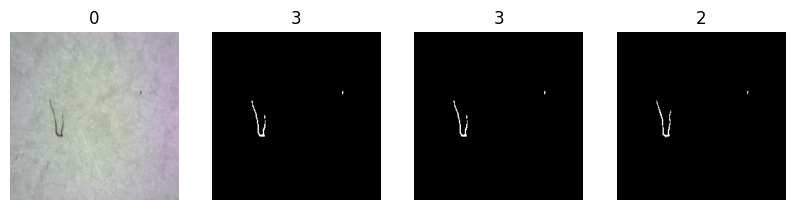

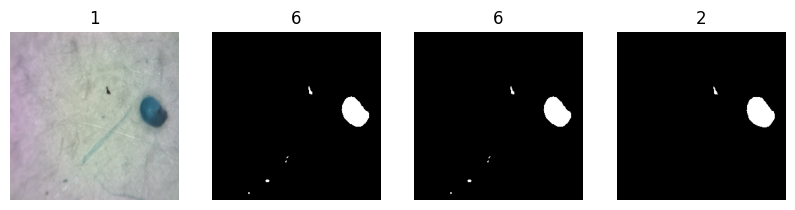

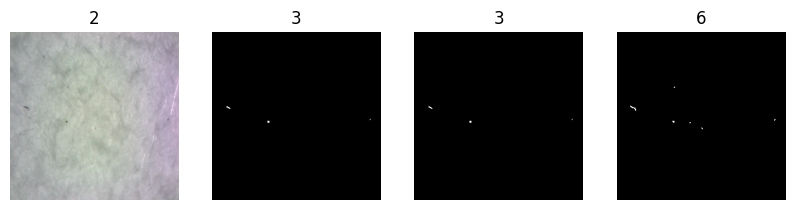

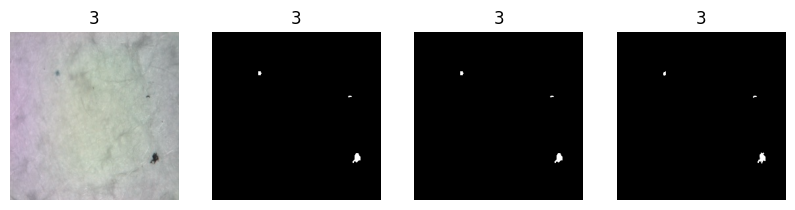

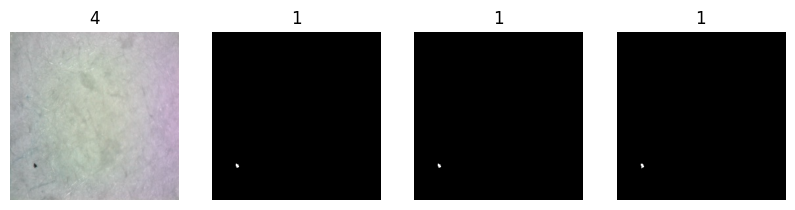

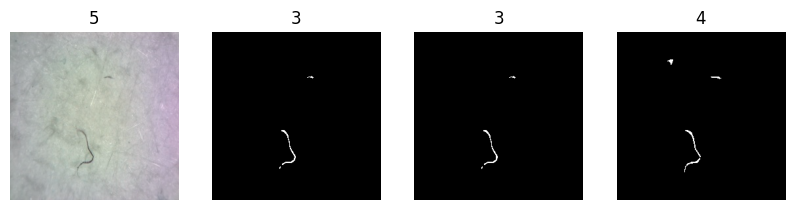

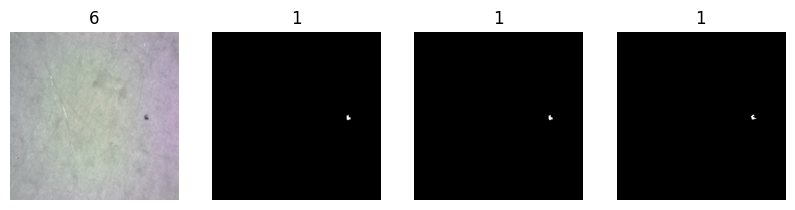

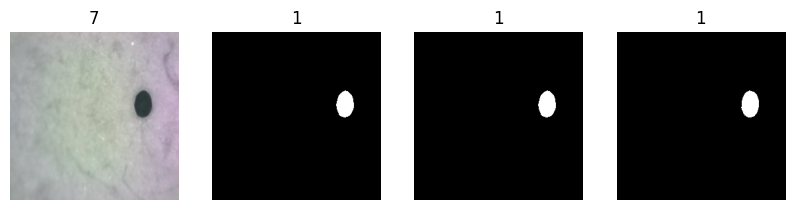

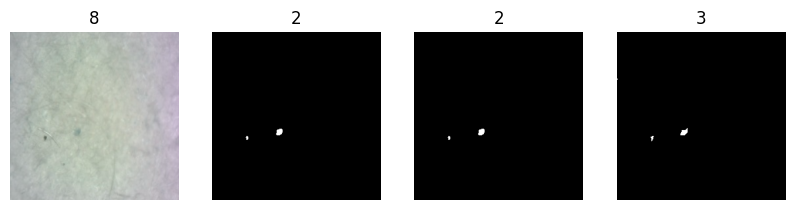

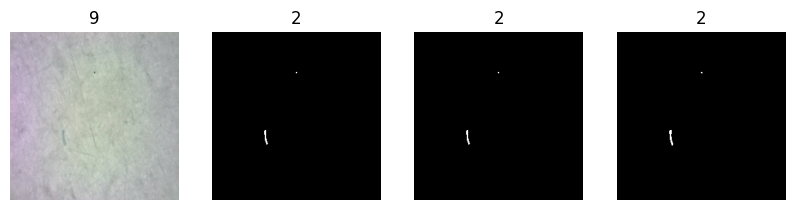

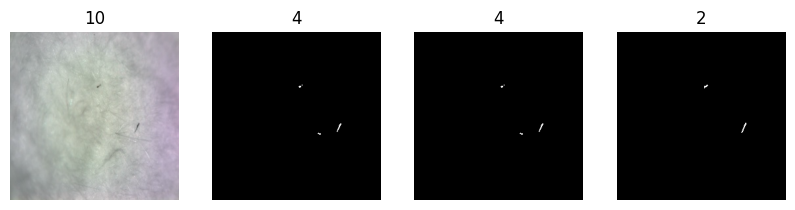

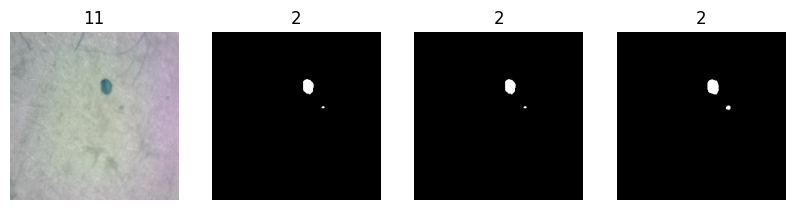

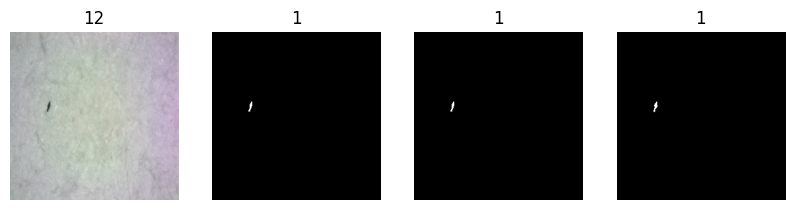

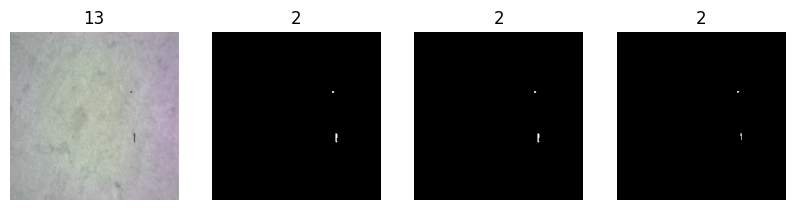

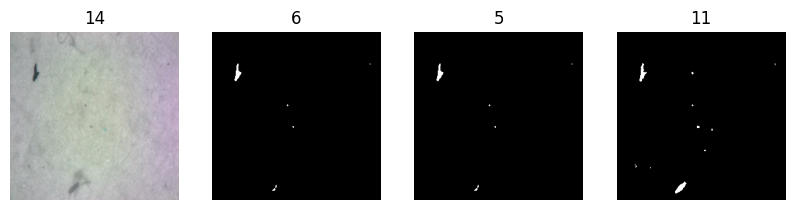

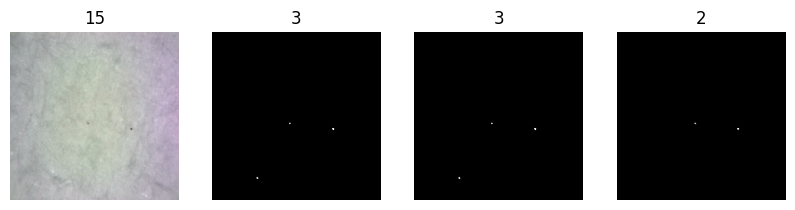

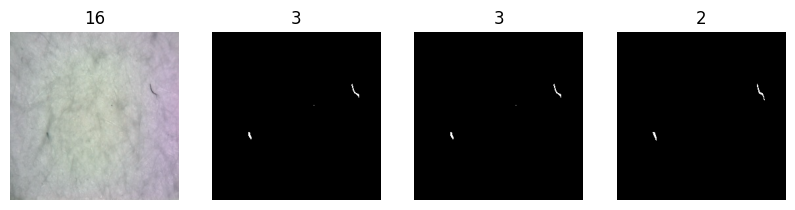

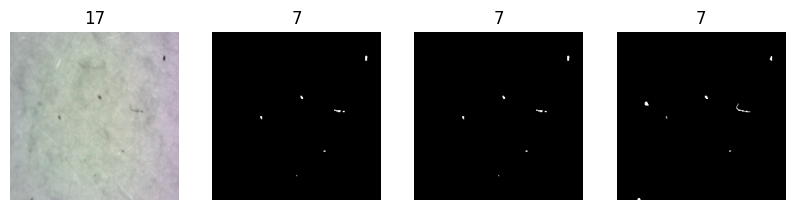

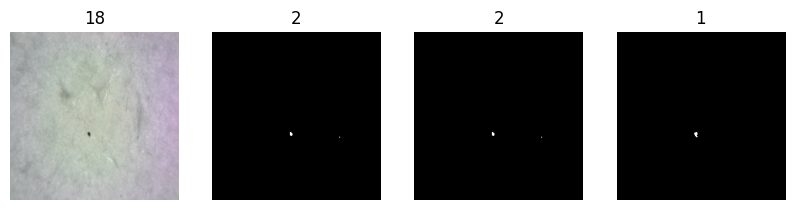

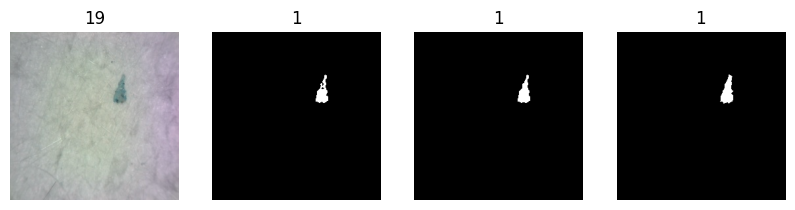

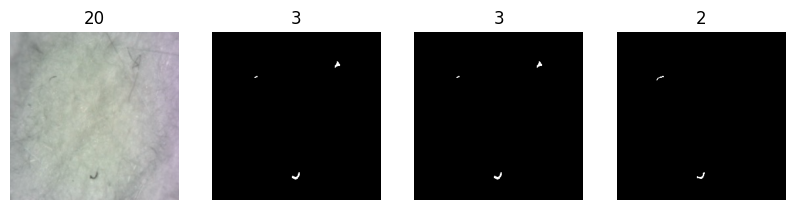

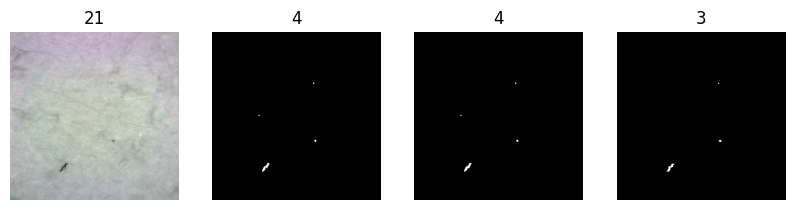

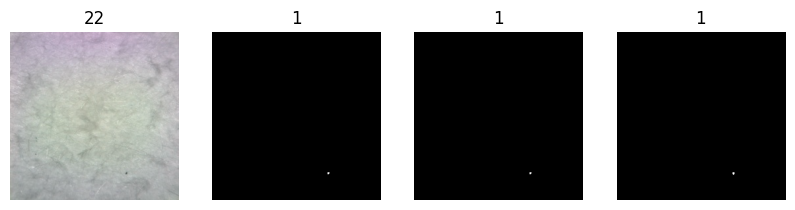

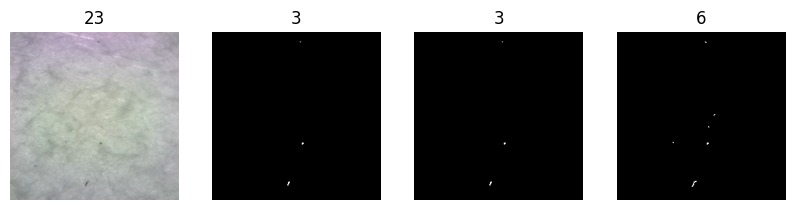

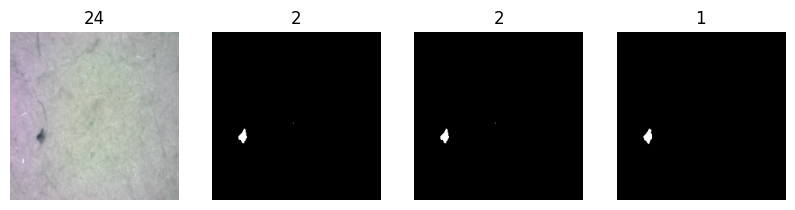

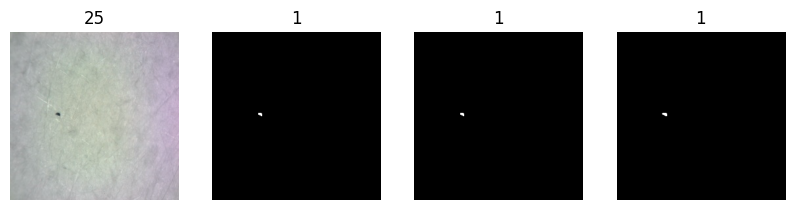

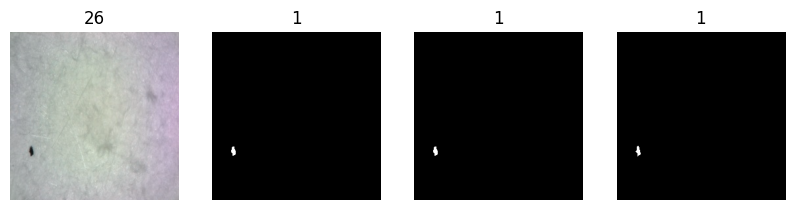

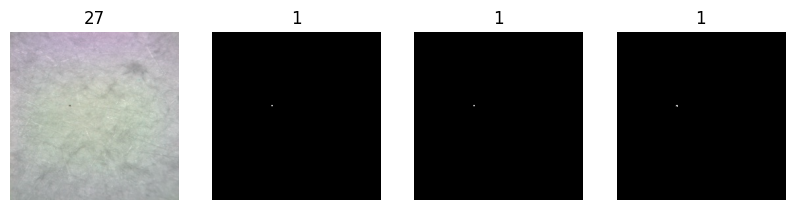

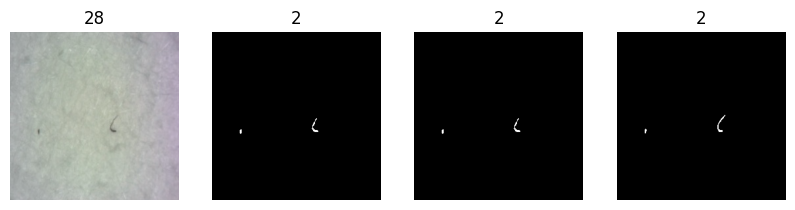

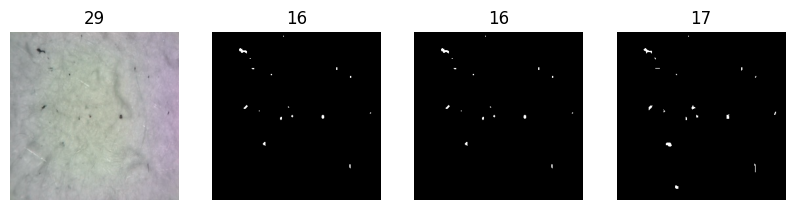

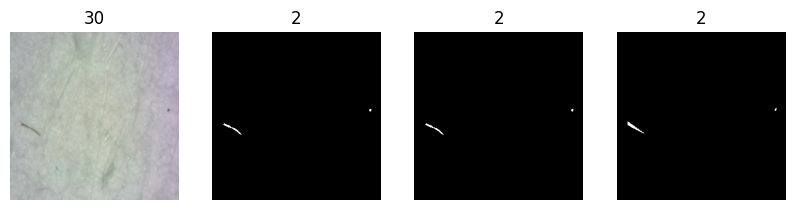

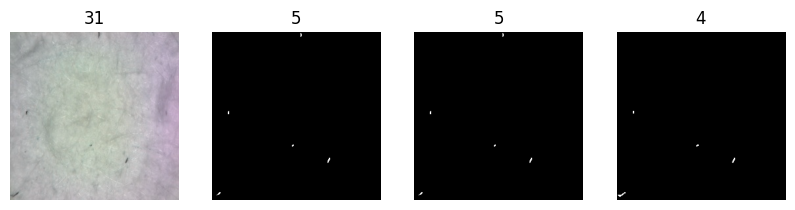

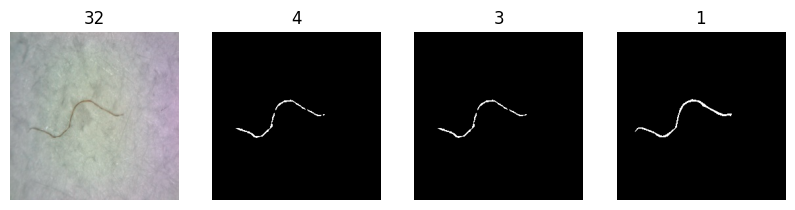

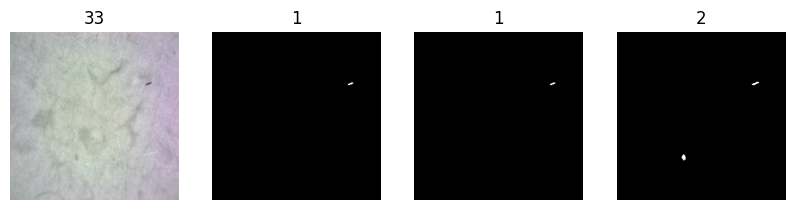

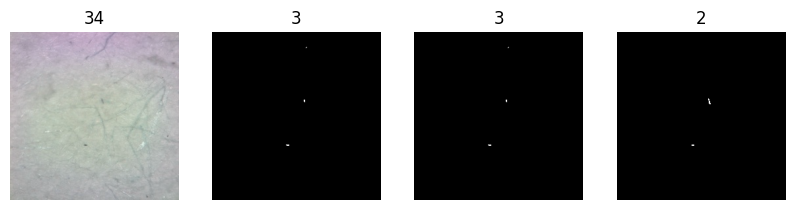

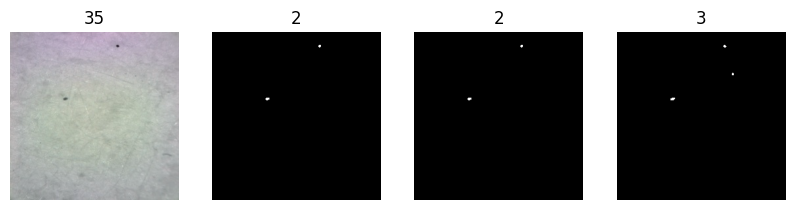

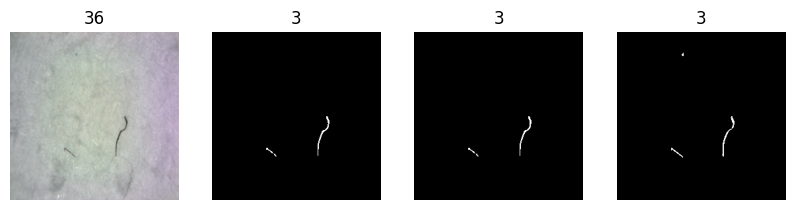

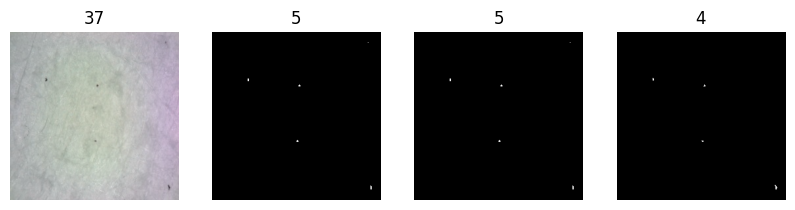

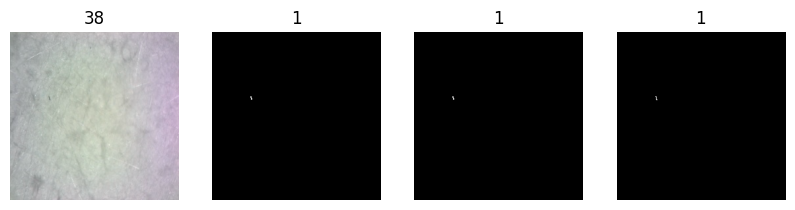

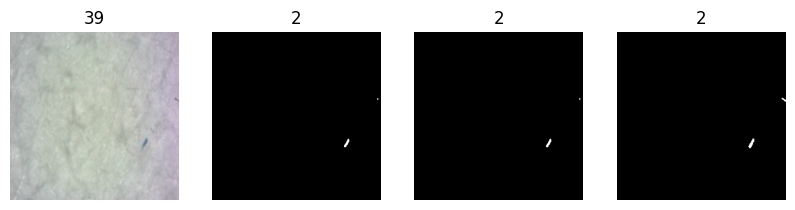

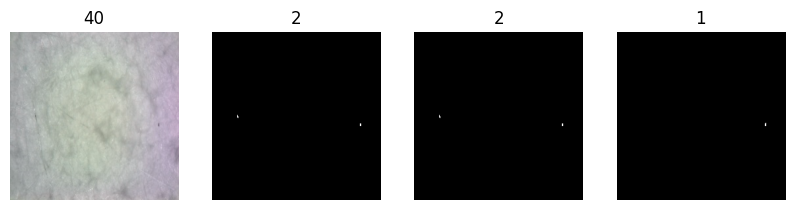

In [ ]:
import time

start = time.time()

total_mp_predicted, total_mp_predicted_morph, total_mp_actual, total_correct, total_correct_morph, mae, mae_morph, mse, mse_morph, deviation, deviation_morph = count_image_blobs(x_test, y_test, save_counts=True, model_name="combo")
end = time.time()
print("time:", end - start)

print(f'Counting with model {current_model}:')
print(f'Total predicted {total_mp_predicted}, total predicted morph {total_mp_predicted_morph}, total actual: {total_mp_actual}')
print(f'Num correct {total_correct}, num correct morph {total_correct_morph}')
print(f'Prop correct {round(total_correct / len(x_test) * 100, 2)}%, prop correct morph {round(total_correct_morph / len(x_test) * 100, 2)}%')
print(f'MAE {mae}, MAE morph {mae_morph}')
print(f'MSE {mse}, MSE morph {mse_morph}')
print(f'Deviation {round(deviation * 100, 2)}%, deviation morph {round(deviation_morph * 100, 2)}%')

### Evaluate model each 10 epochs

In [ ]:
all_checkpoints = os.listdir(checkpoints_augmented_dir)
filtered_checkpoints = list(filter(lambda checkpoint: True if checkpoint.startswith(current_model) else False, all_checkpoints))

def load_model_and_test(checkpoint):
  checkpoint_dir = os.path.join(checkpoints_augmented_dir, checkpoint)
  print("\nCurrent checkpoint", checkpoint)
  unet_model = build_and_compile_model()

  predictions = unet_model.predict(x_test)
  calculate_metrics_for_predictions(predictions)

  total_mp_predicted, total_mp_predicted_morph, total_mp_actual, total_correct, total_correct_morph, mae, mae_morph, mse, mse_morph, deviation, deviation_morph = count_image_blobs(x_test, y_test, predictions=predictions, model_name=current_model)

  print(f'Total predicted {total_mp_predicted}, total predicted morph {total_mp_predicted_morph}, total actual: {total_mp_actual}')
  print(f'Num correct {total_correct}, num correct morph {total_correct_morph}')
  print(f'Prop correct {round(total_correct / len(x_test) * 100, 2)}%, prop correct morph {round(total_correct_morph / len(x_test) * 100, 2)}%')
  print(f'MAE {mae}, MAE morph {mae_morph}')
  print(f'MSE {mse}, MSE morph {mse_morph}')
  print(f'Deviation {round(deviation * 100, 2)}%, deviation morph {round(deviation_morph * 100, 2)}%')

for count, checkpoint in enumerate(filtered_checkpoints, 1): # Start counting from 1
  # if count % 10 == 0:
  load_model_and_test(checkpoint)

In [ ]:
all_checkpoints = os.listdir(checkpoints_augmented_dir)
filtered_checkpoints = list(filter(lambda checkpoint: True if checkpoint.startswith(current_model) else False, all_checkpoints))

for count, checkpoint in enumerate(filtered_checkpoints, 1): # Start counting from 1
  if count % 10 != 0:
    os.remove(os.path.join(checkpoints_augmented_dir, checkpoint))

### Model metrics graph

### Show metric graphs

In [ ]:
# Show metric graphs
import matplotlib.pyplot as plt

def show_training_metrics(data):
  # Plot training and validation accuracy
  plt.figure(figsize=(12, 6))
  plt.subplot(2, 2, 1)
  plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
  plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot training and validation loss
  plt.subplot(2, 2, 2)
  plt.plot(data['epoch'], data['loss'], label='Training Loss')
  plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Plot validation F1 Score, Precision, and Recall
  plt.subplot(2, 2, 3)
  plt.plot(data['epoch'], data['val_f1_score'], label='Validation F1 Score')
  plt.plot(data['epoch'], data['val_precision'], label='Validation Precision')
  plt.plot(data['epoch'], data['val_recall'], label='Validation Recall')
  plt.title('Validation F1 Score, Precision, and Recall')
  plt.xlabel('Epoch')
  plt.ylabel('Metric Value')
  plt.legend()

  # Plot validation F1 Score, Precision, and Recall
  plt.subplot(2, 2, 4)
  plt.plot(data['epoch'], data['val_binary_io_u'], label='Validation Binary IoU')
  plt.title('Validation Binary IoU')
  plt.xlabel('Epoch')
  plt.ylabel('Metric Value')
  plt.legend()

  plt.tight_layout()
  plt.show()

Metrics of focal_tversky_5_hsv


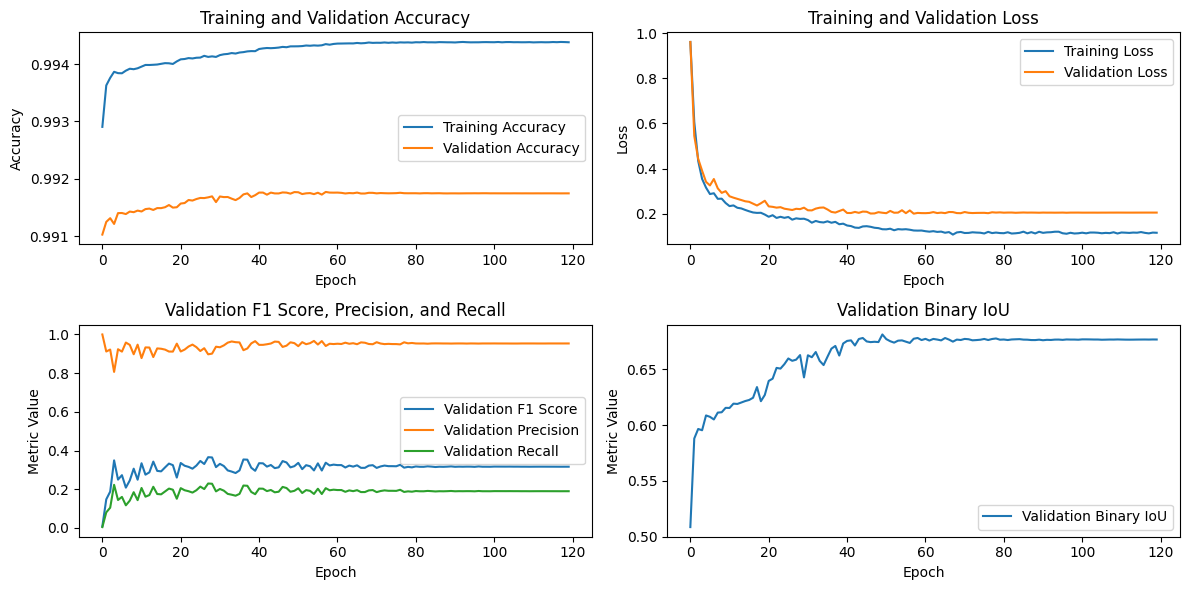

In [ ]:
# Load the CSV file
data = pd.read_csv(current_logger_dir)

print("Metrics of", current_model)
show_training_metrics(data)

### Compile best model

In [ ]:
val_loss = data['val_loss'][best_index]
model_name = f'weights.{best_epoch}-{round(val_loss, 2)}.hdf5'
best_model_checkpoint_dir = os.path.join(checkpoints_augmented_dir, model_name)

unet_model.load_weights(best_model_checkpoint_dir)

In [ ]:
unet_model.evaluate(val_dataset)

3/3 [==============================] - 32s 7s/step - loss: 0.0407 - accuracy: 0.9928 - binary_io_u: 0.6206 - precision: 0.4417 - recall: 0.6100 - f1_score: 0.5124


[0.04068025201559067,
 0.9927528500556946,
 0.6205804347991943,
 0.441663533449173,
 0.6100186109542847,
 0.5123657584190369]

In [ ]:
unet_model.evaluate(val_dataset)

3/3 [==============================] - 27s 7s/step - loss: 0.0407 - accuracy: 0.9928 - binary_io_u_2: 0.6730 - precision_4: 0.5812 - recall_4: 0.5271 - f1_score: 0.5528


[0.04068025201559067,
 0.9927528500556946,
 0.673003613948822,
 0.5811936259269714,
 0.5271165370941162,
 0.5528357028961182]

# Kursinio paveiksleliai/figuros

In [ ]:
# Load the CSV file
data = pd.read_csv(current_logger_dir)

### Load single image for testing

In [ ]:
img_name = "20211223110538.jpg"
image_path = os.path.join(resized_images_dir, img_name)
mask_path = os.path.join(resized_masks_dir, img_name)
img = cv.imread(image_path) / 255.0
mask = cv.imread(mask_path) / 255.0

### Augmentation example

In [ ]:
augmented_image, augmented_mask = augment(img, mask, override_augmentation=0)

augmented_path = os.path.join(resized_images_dir, img_name.replace(".jpg", "_horflip.jpg"))
# cv.imwrite(augmented_path, augmented_image.numpy() * 255.0)
show_images(img, mask)
show_images(augmented_image, augmented_mask)

### Create image for showcasing binary segmentation

In [ ]:
temp_img = np.expand_dims(img, axis=0)
predicted_mask = unet_model.predict(temp_img)
predicted_mask = np.squeeze(predicted_mask, axis=0)
# predicted_mask = np.where(predicted_mask < 0.5, 0, 1)

1/1 [==============================] - 1s 740ms/step


(44, 44, 3)


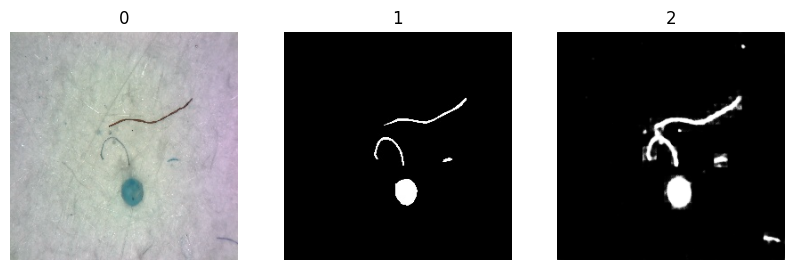

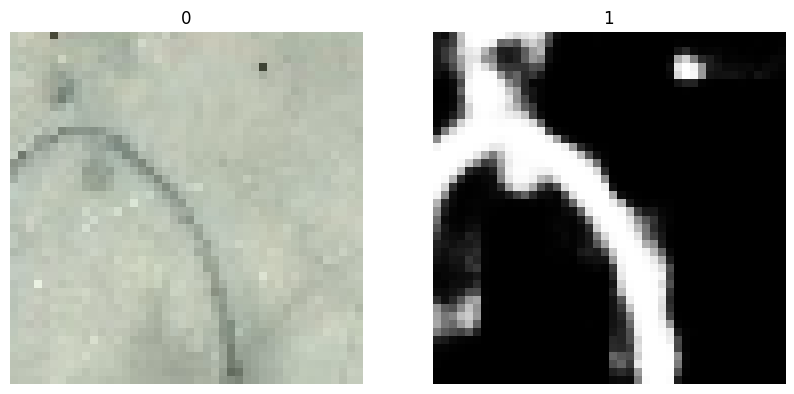

In [ ]:
def zoom(image, mask, zoom_factor):
  new_image = tf.image.central_crop(image, central_fraction=1/zoom_factor)  # Zoom in to 70% of the image
  # new_image = tf.image.resize(new_image, [INPUT_SHAPE[0], INPUT_SHAPE[1]])
  new_mask = tf.image.central_crop(mask, central_fraction=1/zoom_factor)
  # new_mask = tf.image.resize(new_mask, [INPUT_SHAPE[0], INPUT_SHAPE[1]])
  return new_image, new_mask

img_zoom, mask_zoom = zoom(img, predicted_mask, 6)
show_images(img, mask, predicted_mask)
show_images(img_zoom, mask_zoom)

print(img_zoom.shape)

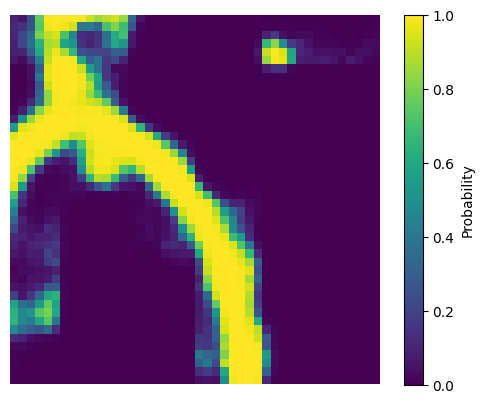

In [ ]:
# Save the original image
plt.imshow(img_zoom)
plt.axis('off')  # Turn off axis
plt.savefig(os.path.join(figures_dir, "segmentation_image.png"), bbox_inches='tight', pad_inches=0)

# Save the segmentation mask
plt.imshow(mask_zoom, cmap='viridis', vmin=0, vmax=1)
plt.axis('off')  # Turn off axis
plt.colorbar(label='Probability')
plt.savefig(os.path.join(figures_dir, "segmentation_mask.png"), bbox_inches='tight', pad_inches=0)

### Create img for dice loss training

In [ ]:
plt.rcParams.update({'font.size': 14})

Metrics of dice_smooth_1eminus5_thresh_50_relu_batch_4_filters_64


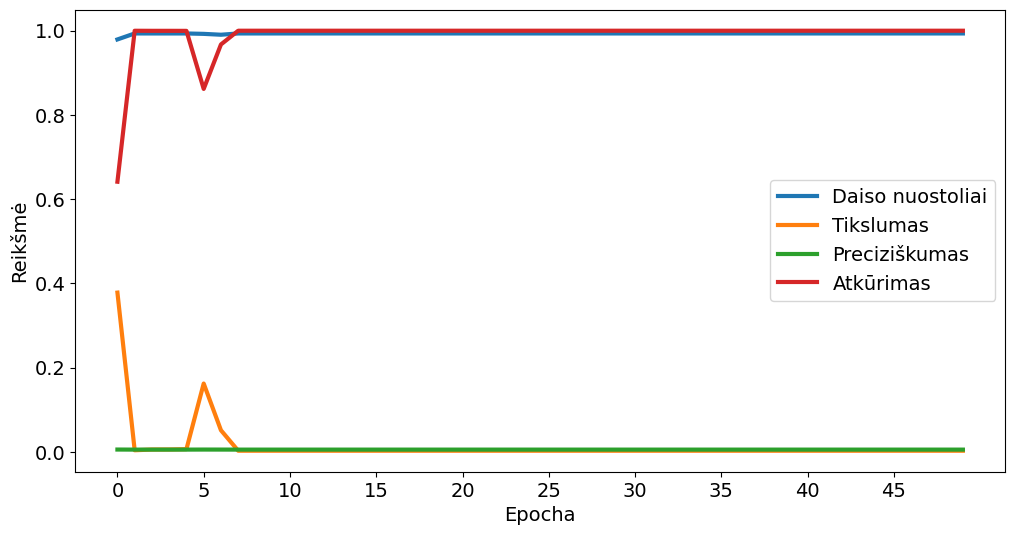

In [ ]:
# Show metric graphs
import matplotlib.pyplot as plt

epochs = 50

def show_training_metrics(data):
  # Plot training and validation accuracy
  plt.figure(figsize=(12, 6))
  linewidth=3.0
  plt.plot(data['epoch'], data['loss'], label='Daiso nuostoliai', linewidth=linewidth)
  # plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
  plt.plot(data['epoch'], data['accuracy'], label='Tikslumas', linewidth=linewidth)
  plt.plot(data['epoch'], data['precision'], label='Preciziškumas', linewidth=linewidth)
  plt.plot(data['epoch'], data['recall'], label='Atkūrimas', linewidth=linewidth)
  # plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
  # plt.title('Dice loss training metrics')
  plt.xlabel('Epocha')
  plt.ylabel('Reikšmė')
  plt.xticks(np.arange(0, epochs, 5))
  plt.legend()

  plt.savefig(os.path.join(figures_dir, "dice_training.png"), bbox_inches='tight', pad_inches=0.1)
  plt.show()

print("Metrics of", current_model)
show_training_metrics(data[:epochs])

### Save test dataset images for latex

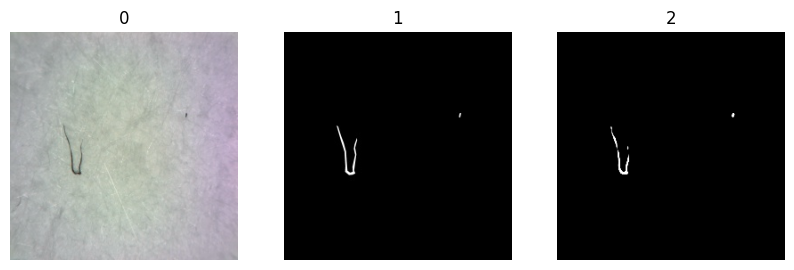

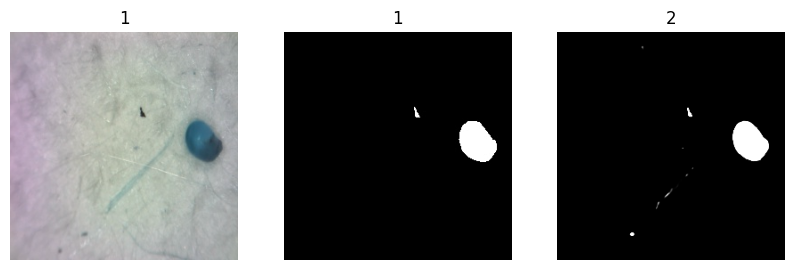

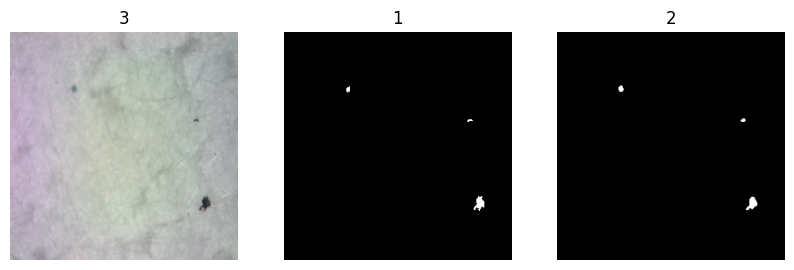

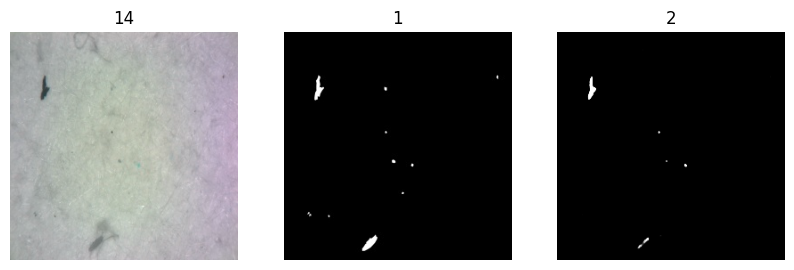

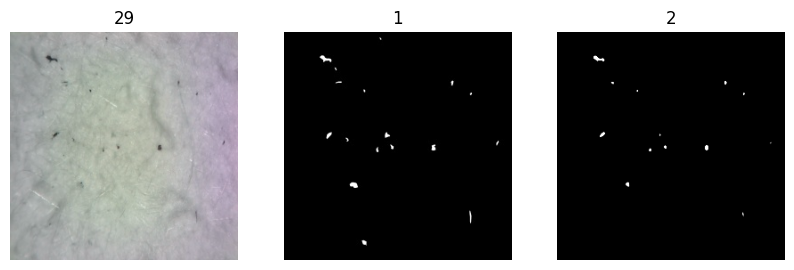

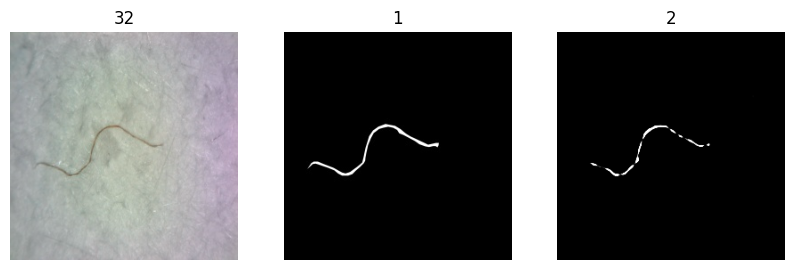

In [ ]:
from PIL import Image

figures_test_dir = os.path.join(figures_dir, "test_dataset")
figures_wbce_test_dir = os.path.join(figures_dir, "test_dataset_wbce")

def save_numpy_as_image(array, path):
    """
    Saves a numpy array as an image.

    Parameters:
        array (numpy.ndarray): The image data as a numpy array.
        path (str): The path where the image will be saved.
    """
    # If the image is binary (i.e., has a shape like (256, 256, 1)),
    # we should first remove the singleton dimension before saving it
    if array.ndim == 3 and array.shape[-1] == 1:
        array = array.squeeze(-1)

    # Convert the numpy array to a PIL image
    image = Image.fromarray(np.uint8(array * 255))

    # Save the image
    image.save(path)

    print(f"Image saved as {path}")


def save_image(ds_x, ds_y, predictions, index, dir=figures_test_dir):
  image = ds_x[index]
  labels = ds_y[index]
  prediction = predictions[index]

  save_numpy_as_image(image, os.path.join(dir, "image_" + str(index) + ".png"))
  save_numpy_as_image(labels, os.path.join(dir, "label_" + str(index) + ".png"))
  save_numpy_as_image(prediction, os.path.join(dir, "prediction_" + str(index) + ".png"))

def show_test_images(ds_x, ds_y, predictions, index):
  image = ds_x[index]
  labels = ds_y[index]
  prediction = predictions[index]
  show_images([index], image, labels, prediction)

# save_image(x_test, y_test, base_predictions, 0, figures_wbce_test_dir)
# save_image(x_test, y_test, base_predictions, 1, figures_wbce_test_dir)
# save_image(x_test, y_test, base_predictions, 3, figures_wbce_test_dir)
# save_image(x_test, y_test, base_predictions, 14, figures_wbce_test_dir)
# save_image(x_test, y_test, base_predictions, 29, figures_wbce_test_dir)
# save_image(x_test, y_test, base_predictions, 32, figures_wbce_test_dir)
show_test_images(x_test, y_test, base_predictions, 0)
show_test_images(x_test, y_test, base_predictions, 1)
show_test_images(x_test, y_test, base_predictions, 3)
show_test_images(x_test, y_test, base_predictions, 14)
show_test_images(x_test, y_test, base_predictions, 29)
show_test_images(x_test, y_test, base_predictions, 32)

## Test models

In [ ]:
models = os.listdir(models_dir)
index = models.index("dice_wbce_1")
models = models[index:]
params = {

}

def evaluate_model(model_name):
  POS_WEIGHT = 300
  unet_model = tf.keras.saving.load_model(
    current_model_dir,
    custom_objects={
        "F1Score": F1Score,
        "dice_with_wbce": dice_with_wbce,
        "dice_loss": dice_loss,
        "wbce": wbce,
        "focal_tversky": focal_tversky
    },
  )
  evaluation = unet_model.evaluate(x_test, y_test)
  print(evaluation)


# for model_name in models:
#   set_current_model(model_name)
#   evaluate_model(model_name)
#   break;
evaluate_model("wbce_1")

2/2 [==============================] - 85s 18s/step - loss: 0.1872 - accuracy: 0.9945 - binary_io_u: 0.7294 - precision: 0.9285 - recall: 0.3839 - f1_score: 0.5432
[0.187230184674263, 0.9945113062858582, 0.7294446229934692, 0.9285323619842529, 0.3838549256324768, 0.543165385723114]
